# DeepSet Flow Matching Posterior Estimation

This notebook demonstrates how to perform flow matching posterior estimation (FMPE) using a DeepSet architecture with LAMPE.

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import zuko

from itertools import islice
from lampe.data import JointLoader
from lampe.plots import corner, mark_point, nice_rc
from lampe.utils import GDStep
from tqdm import trange

from fmpe_deep_sets import DeepSetFMPE, DeepSetFMPELoss

## Simulator

We define a simple simulator function and a prior distribution for our parameters. The simulator mimics the generation of observations based on the input parameters.

In [2]:
LABELS = [r'$\theta_1$', r'$\theta_2$', r'$\theta_3$']
LOWER = -torch.ones(3)
UPPER = torch.ones(3)

prior = zuko.distributions.BoxUniform(LOWER, UPPER)

def simulator(theta: torch.Tensor) -> torch.Tensor:
    x = torch.stack([
        theta[..., 0] + theta[..., 1] * theta[..., 2],
        theta[..., 0] * theta[..., 1] + theta[..., 2],
    ], dim=-1)

    return x + 0.05 * torch.randn_like(x)

theta = prior.sample()
x = simulator(theta)

print(theta, x, sep='\n')

tensor([-0.4032, -0.3083, -0.0811])
tensor([-0.4237,  0.0130])


In [3]:
loader = JointLoader(prior, simulator, batch_size=256, vectorized=True)

## Training

We train a DeepSetFMPE model to learn the vector field that induces a normalizing flow between the posterior distribution $p(\theta | x)$ and a standard Gaussian distribution $\mathcal{N}(0, I)$. The training involves minimizing the FMPE loss.

In [4]:
estimator = DeepSetFMPE(theta_dim=3, x_dim=2, freqs=5)
loss = DeepSetFMPELoss(estimator)
optimizer = optim.Adam(estimator.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 128)
step = GDStep(optimizer, clip=1.0)  # gradient descent step with gradient clipping

estimator.train()

for epoch in (bar := trange(128, unit='epoch')):
    losses = []

    for theta, x in islice(loader, 256):  # 256 batches per epoch
        losses.append(step(loss(theta, x)))

    bar.set_postfix(loss=torch.stack(losses).mean().item())

100%|██████████| 128/128 [00:26<00:00,  4.77epoch/s, loss=0.34] 


## Inference

After training, we use the DeepSetFMPE model to perform inference. We sample from the normalizing flow $p_\phi(\theta | x)$ it induces.

In [5]:
theta_star = prior.sample()
x_star = simulator(theta_star)

estimator.eval()

with torch.no_grad():
    log_p = estimator.flow(x_star).log_prob(theta_star)
    samples = estimator.flow(x_star).sample((2**14,))

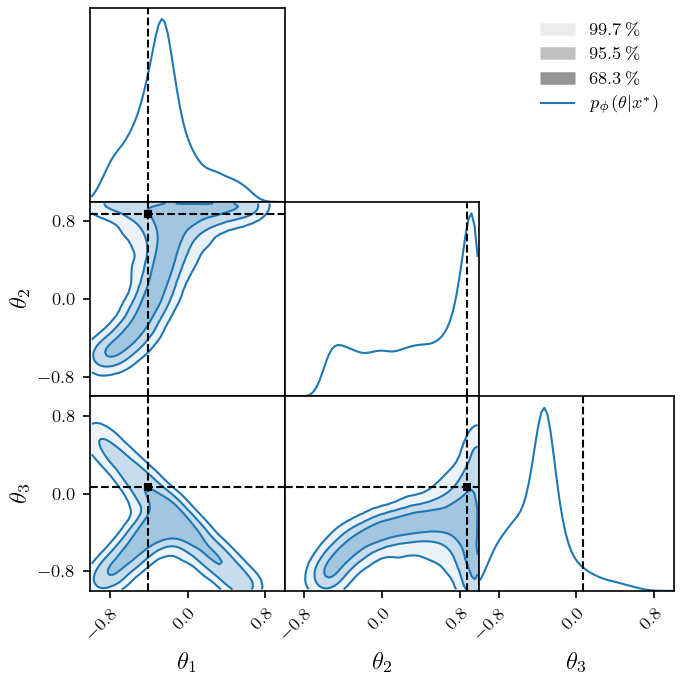

In [6]:
plt.rcParams.update(nice_rc(latex=True))  # nicer plot settings

fig = corner(
    samples,
    smooth=2,
    domain=(LOWER, UPPER),
    labels=LABELS,
    legend=r'$p_\phi(\theta | x^*)$',
    figsize=(4.8, 4.8),
)

mark_point(fig, theta_star)